In [6]:

from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
from typing import List


sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")

volatile_ll = Path("allocator/latest-dram")
peristent_ll = Path("allocator/latest-nvram")


def read_orders(dir: str, orders: List[int]) -> pd.DataFrame:
    data = []
    for o in orders:
        d = pd.read_csv(f"{dir}/out_{o}.csv")
        d["order"] = str(o)
        data.append(d)
    data = pd.concat(data)
    data["cores"] = data["x"]
    data["alloc"] = data["get_avg"]
    data["free"] = data["put_avg"]
    return data[["order", "cores", "iteration", "alloc", "free"]]

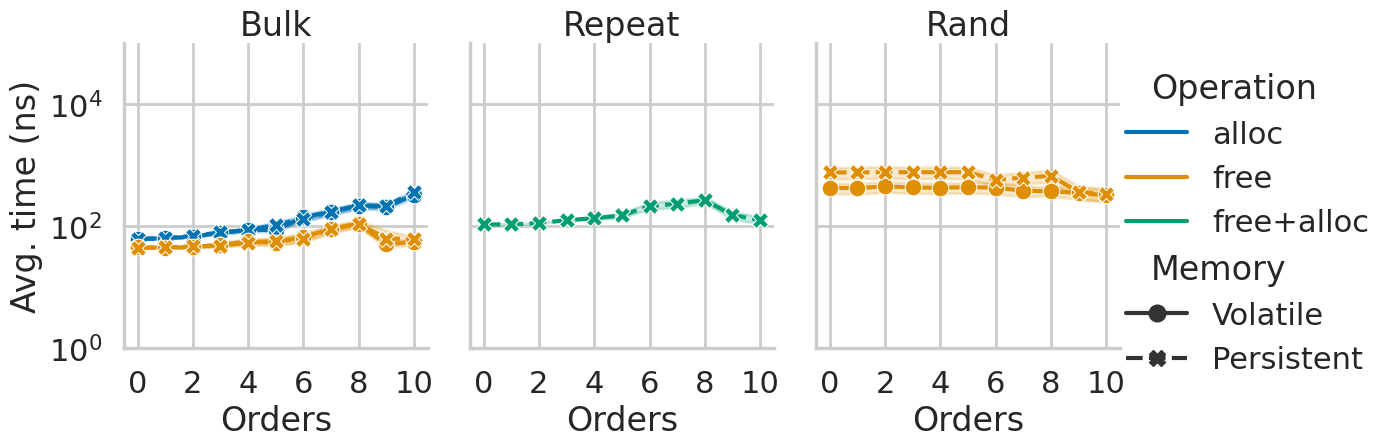

In [8]:
data_b = read_orders(volatile_ll / "bulk", list(range(11)))
data_b["bench"] = "Bulk"
data_b["Memory"] = "Volatile"
data_r = read_orders(volatile_ll / "repeat", list(range(11)))
data_r["bench"] = "Repeat"
data_r["alloc+free"] = data_r["alloc"]
data_r["alloc"] = np.nan
data_r["free"] = np.nan
data_r["Memory"] = "Volatile"
data_a = read_orders(volatile_ll / "rand", list(range(11)))
data_a["bench"] = "Rand"
data_a["alloc"] = np.nan
data_a["Memory"] = "Volatile"

data_p_b = read_orders(peristent_ll / "bulk", list(range(11)))
data_p_b["bench"] = "Bulk"
data_p_b["Memory"] = "Persistent"
data_p_r = read_orders(peristent_ll / "repeat", list(range(11)))
data_p_r["bench"] = "Repeat"
data_p_r["free+alloc"] = data_p_r["alloc"]
data_p_r["alloc"] = np.nan
data_p_r["free"] = np.nan
data_p_r["Memory"] = "Persistent"
data_p_a = read_orders(peristent_ll / "rand", list(range(11)))
data_p_a["bench"] = "Rand"
data_p_a["alloc"] = np.nan
data_p_a["Memory"] = "Persistent"

data = pd.concat([data_b, data_r, data_a, data_p_b, data_p_r, data_p_a])
pgd = data[["bench", "order", "cores", "Memory", "alloc", "free", "free+alloc"]].melt(
    id_vars=["bench", "order", "cores", "Memory"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, col="bench", height=5, aspect=0.8)
    g.map_dataframe(sns.lineplot, x="order", y="time",
                    markers=True, hue="Operation", style="Memory")
    g.add_legend(adjust_subtitles=True)
    # g.set(ylim=(0, None))
    g.set(ylim=(1, 10**5))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Orders")
    g.set(xticks=[0, 2, 4, 6, 8, 10])
    g.set_titles("{col_name}")
    g.savefig("out/llfree_raw.pdf")
